In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


In [2]:
immigration_data_2012_2021 = "Resources/immigration_data_2005_2021.csv"
#state_unemployment = "Resources/emp-unemployment.xls"
#gini = "Resources/gini_index_by_state_2016_2018.xlsx"

In [3]:
inmigration = pd.read_csv(immigration_data_2012_2021)
inmigration.head()

,Year,Region and country of birth,Total Permanent Residents,Percentage,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
0,2005,Total,1122373,100.00,4200,1525,18988,2698,232023,11977,...,27100,26482,847,7909,321,128,5868,0,0,0
1,2005,"China, People's Republic",69967,6.23,328,92,543,202,17668,765,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,2.45,5,42,22,0,82,6,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,7.54,431,15,739,215,14724,516,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,1.24,48,4,285,9,7059,131,...,562,318,18,48,0,0,0,0,0,0


## Cleaning country regressor dataset

In [4]:
#Read the csv
countries_raw_metadata = pd.read_csv("Resources/countries_metadata.csv", encoding='latin-1')
display(countries_raw_metadata.head())
print(countries_raw_metadata.shape)

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


(70, 67)


In [5]:
#Delete the "[YR..]" in the year columns
for column in countries_raw_metadata.columns:
    if "[YR" in column:
        new_column_name = column.split("[")[0].strip() # Extract the part before '[YR' and remove any leading/trailing spaces
        countries_raw_metadata.rename(columns={column: new_column_name}, inplace=True)
countries_raw_metadata.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [6]:
#Clean the "Country Names" columns 
unique_names = countries_raw_metadata["Country Name"].unique()
unique_names

array(['China', 'United States', 'Iran, Islamic Rep.', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines', nan,
       'Data from database: World Development Indicators',
       'Last Updated: 06/29/2023', 'Code', 'SP.POP.TOTL',
       'NY.GDP.PCAP.CD', 'SL.UEM.TOTL.NE.ZS',
       'Unemployment is a key measure to monitor whether a country is on track to achieve the Sustainable Development Goal of promoting sustained',
       'However', 'SP.URB.TOTL.IN.ZS',
       "Percentages urban are the numbers of persons residing in an area defined as ''urban'' per 100 total population. They are calculated by the Statistics Division of the United Nations Department of Economic and Social Affairs. Particular caution should be used in interpreting the figures for percentage urban for different countries.",
       'Countries differ in the way they classify population as "urban" or "rural." The population of a city or metropolitan area depends on the bou

In [7]:
#List the country names we want to keep.
attributes_to_keep = ['China', 'United States', 'Iran, Islamic Rep.', 'India', 'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan', 'Philippines']

# Filter the DataFrame to keep only the desired attributes
df_filtered = countries_raw_metadata[countries_raw_metadata['Country Name'].isin(attributes_to_keep)]

# Print the filtered DataFrame
df_filtered.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [8]:
#Prepare the "Series Name" to move it to the columns, these will be our regressors. 
series_names = df_filtered["Series Name"].unique()
series_names

array(['Population, total', 'GDP per capita (current US$)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'Urban population (% of total population)',
       'Birth rate, crude (per 1,000 people)', 'Gini index'], dtype=object)

In [9]:
df_filtered.loc[df_filtered["Series Name"] == 'Population, total', "Series Name"] = "Population_total"
df_filtered.loc[df_filtered["Series Name"] == 'GDP per capita (current US$)', "Series Name"] = "GDP_per_capita"
df_filtered.loc[df_filtered["Series Name"] == 'Unemployment, total (% of total labor force) (national estimate)', "Series Name"] = "UR"
df_filtered.loc[df_filtered["Series Name"] == 'Urban population (% of total population)', "Series Name"] = "Urban_population"
df_filtered.loc[df_filtered["Series Name"] == 'Birth rate, crude (per 1,000 people)', "Series Name"] = "Birth_rate_crude"
df_filtered.loc[df_filtered["Series Name"] == 'Gini index', "Series Name"] = "Gini_index"
df_filtered.loc[df_filtered["Country Name"] == 'Iran, Islamic Rep.', "Country Name"] = "Iran"
df_filtered

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,Population_total,SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP_per_capita,NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,UR,SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban_population,SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,Birth_rate_crude,SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..
5,China,CHN,Gini_index,SI.POV.GINI,..,..,..,..,..,..,...,39.7,39.2,38.6,38.5,39.1,3.850000e+01,38.2,..,..,..
6,United States,USA,Population_total,SP.POP.TOTL,180671000,183691000,186538000,189242000,191889000,194303000,...,316059947,318386329,320738994,323071755,325122128,3.268382e+08,328329953,331511512,332031554,333287557
7,United States,USA,GDP_per_capita,NY.GDP.PCAP.CD,3007.12344537862,3066.56286916615,3243.84307754988,3374.51517105082,3573.94118474743,3827.52710972039,...,53291.1276891406,55123.8497869046,56762.7294515989,57866.7449341091,59907.754260885,6.282331e+04,65120.3946628653,63528.6343027508,70219.472454115,76398.5917422054
8,United States,USA,UR,SL.UEM.TOTL.NE.ZS,5.5,6.7,5.5,5.7,5.2,4.5,...,7.37,6.17,5.28,4.87,4.36,3.900000e+00,3.67,8.05,5.35,3.65
9,United States,USA,Urban_population,SP.URB.TOTL.IN.ZS,69.996,70.377,70.757,71.134,71.508,71.879,...,81.299,81.483,81.671,81.862,82.058,8.225600e+01,82.459,82.664,82.873,83.084


In [10]:
# Get rid the unnecessary columns
countries_regressors_raw = df_filtered.drop(columns= {"Country Code", "Series Code"} )
countries_regressors_raw.head()

,Country Name,Series Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,Population_total,667070000,660330000,665770000,682335000,698355000,715185000,735400000,754550000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,GDP_per_capita,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,104.324189073855,96.58918279471,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,UR,..,..,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,Urban_population,16.203,16.708,17.226,17.757,18.299,18.086,17.915,17.785,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,Birth_rate_crude,20.86,18.02,37.01,43.37,39.14,37.88,35.05,33.96,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [11]:
#countries_regressors_raw.info()

### Cleaning US state regressors

In [12]:
variables_by_state_raw = pd.read_csv("Resources/variable 2011-2021.csv")
variables_by_state_rename = variables_by_state_raw.rename(columns={"Unemployeement Rate": "UR_STATE",
                                                                  "GDP Per Capita":"GDP_per_capita_state", "Birth Rate":"Bith_rate_state"  })

# Multiply the "unemployment rate" column by 10
variables_by_state_rename["UR_STATE"] *= 10

## Cleaning inmigration csv

In [13]:
migration = inmigration.rename(columns={"Region and country of birth": "Country_origin", "Total Permanent Residents": "Total_inmigrants"})
migration = migration[migration["Country_origin"]!= "Total"]
migration = migration.drop(columns="Percentage")
migration["Country_origin"] = migration["Country_origin"].replace("China, People's Republic", "China")
migration

,Year,Country_origin,Total_inmigrants,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
1,2005,China,69967,328,92,543,202,17668,765,894,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,5,42,22,0,82,6,319,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,431,15,739,215,14724,516,1571,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,48,4,285,9,7059,131,88,...,562,318,18,48,0,0,0,0,0,0
5,2005,Mexico,161445,569,96,8373,870,63092,2891,316,...,870,2330,30,1054,75,0,129,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021,Iran,5734,21,0,86,17,2206,89,39,...,218,187,9,38,0,0,0,0,0,0
149,2021,Mexico,107230,323,33,6859,610,31715,3131,247,...,586,2539,20,949,69,0,0,0,0,39
150,2021,Pakistan,9691,31,0,59,41,1104,52,111,...,784,166,17,57,3,0,0,0,0,0
151,2021,Philippines,27511,152,190,555,129,6478,228,178,...,648,737,69,236,27,0,0,0,300,9


### Create a Database and store the cleaned dataset

In [14]:
# Create database with the desired file name for your SQLite database
conn = sqlite3.connect('use_migration.db')

# Store DatFrames in the database
migration.to_sql('migration', conn, index=False,  if_exists='replace')
countries_regressors_raw.to_sql('countries_regressors_raw', conn, index=False,  if_exists='replace')
variables_by_state_rename.to_sql('variables_by_state_rename', conn, index=False,  if_exists='replace')
conn.close()

In [15]:
## Check if the DataFrames have been successfully stored in the SQLite database

# Connect to the SQLite database
conn = sqlite3.connect('use_migration.db')

# Read the data from the database
query = "SELECT * FROM migration;"
df_migration = pd.read_sql_query(query, conn)

query = "SELECT * FROM countries_regressors_raw;"
df_countries_regressors_raw = pd.read_sql_query(query, conn)

query = "SELECT * FROM variables_by_state_rename;"
df_variables_by_state_rename = pd.read_sql_query(query, conn)

# Check the data
#print("Data from migration:")
#print(df_migration)

#print("\nData from countries_regressors_raw:")
#print(df_countries_regressors_raw)

#print("\nData from variables_by_state_rename:")
#print(df_variables_by_state_rename)

# Close the database connection
#conn.close()



### Linear Regression adding regressors

In [35]:
country_names=['China', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines']


state_names=['Alabama', 'Alaska',
       'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']


results_df = pd.DataFrame(columns=['Country', 'State', 'MAE', 'MAPE','pred2023'])
# DataFrame to store predictions
df_predictions = pd.DataFrame()
df_scores = pd.DataFrame()
# Collect all predictions and true values for final R-squared calculation
all_preds = []
all_true = []

for country in country_names:
    
    # Filter by country
    regressor_by_country = df_countries_regressors_raw.loc[countries_regressors_raw["Country Name"]== country]
    # Drop the Country Name column
    drop_countryname = regressor_by_country.drop(columns="Country Name")
    # Transpose rows per columns
    regressor_by_country_not_cleaned = drop_countryname.transpose()
    # Use the first row as the column names
    regressor_by_country_not_cleaned.columns = regressor_by_country_not_cleaned.iloc[0]
    # Drop the first row (previous integer index) since it's now redundant
    regressor_by_country_drop_row = regressor_by_country_not_cleaned.iloc[1:]
    print(country)
    regressor_by_country_reset_index = regressor_by_country_drop_row.reset_index().rename(columns={"index":"Year"})
    #display(regressor_by_country_reset_index)
    regressor_by_country_reset_index["Year"] = regressor_by_country_reset_index["Year"].astype(int)
    regressor_by_country_reset_index["Population_total"] = regressor_by_country_reset_index["Population_total"].astype(int)
    regressor_by_country_reset_index["GDP_per_capita"] = regressor_by_country_reset_index["GDP_per_capita"].astype(float)
    regressor_by_country_reset_index['UR'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["UR"] = regressor_by_country_reset_index["UR"].astype(float)
    regressor_by_country_reset_index["Urban_population"] = regressor_by_country_reset_index["Urban_population"].astype(float)
    regressor_by_country_reset_index['Birth_rate_crude'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Birth_rate_crude"] = regressor_by_country_reset_index["Birth_rate_crude"].astype(float)
    regressor_by_country_reset_index['Gini_index'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Gini_index"] = regressor_by_country_reset_index["Gini_index"].astype(float)
    regressor_by_country = regressor_by_country_reset_index
    
    
    for state in state_names:



        # Getting the DataFrame with the years, total number of inmigrants in the US for a given country and 
        # the number of inmigrants of this country in one US state
        migration.reset_index(drop=True, inplace=True)
        county_origin_us_df = df_migration[migration["Country_origin"]==country]
        country_columns = ["Year","Total_inmigrants",state]
        inmigration_us_df = county_origin_us_df[country_columns]
        print(state)

        #Filter by state
        state_test = df_variables_by_state_rename[variables_by_state_rename["State"]==state]
        regressor_by_state = state_test.drop(columns= "State").reset_index(drop=True)
    
        # First merge inmigration_us_df and regressor_by_country
        df_merged1 = pd.merge(inmigration_us_df, regressor_by_country, on="Year", how="left")

        # Then merge the result with regressor_by_state
        df_merged = pd.merge(df_merged1, regressor_by_state, on="Year", how="left")

        
        # LINEAR REGRESSION
        
        # Handle NaN values in the DataFrame
        # For simplicity, we'll fill the NaN values with the column means
        df_merged.fillna(df_merged.mean(), inplace=True)

        # Prepare the state-specific data, excluding the year 2019
        cols_to_scale = ['Year', 'Population_total', 'GDP_per_capita', 'Urban_population',
                         'Birth_rate_crude', 'Gini_index', 'GDP_per_capita_state', 'UR_STATE']
        X = df_merged[cols_to_scale]  # Features
        y = df_merged[state].values  # Target for the specific state

        # Exclude the year 2019 from the training data
        X_train, y_train = X[X['Year'] != 2019], y[X['Year'] != 2019]
        X_test = X[X['Year'] == 2019]  # Keep the data for the year 2019 for prediction

        # Create a min-max scaler object and apply normalization for training data
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train.drop(columns=['Year']))  # Exclude 'Year' column
        
        

        # Normalize X_test for prediction using the same scaler (handle NaN values)
        X_test_scaled = scaler.transform(X_test.drop(columns=['Year']))
        # Create and train the model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)

        # Check if there are NaN values in the test data before making predictions
        if np.isnan(X_test_scaled).any():
            # Handle NaN values in X_test_scaled using SimpleImputer
            imputer = SimpleImputer(strategy='mean')
            X_test_scaled = imputer.fit_transform(X_test_scaled)
            
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.drop(columns=['Year']).columns)

        print(X_test_scaled_df)

        # Calculate predicted values for the year 2019
        y_pred = model.predict(X_test_scaled)[0]

        # Append predicted and true values to the respective lists
        all_preds.append(y_pred)
        all_true.extend(y_test)

        # Calculate R2 score, RMSE, and MAPE
        from sklearn.metrics import mean_absolute_error
        y_true = df_merged[state][-3:-2].values
        print("2019- Real data for " + country + " " + state + ":" + str(y_true))
        print("2019- Predicted for " + country + " " + state + ": " + str(y_pred))
        mae = mean_absolute_error(y_true, [y_pred])  # Convert y_pred to a one-element array
        print("The MAE while testing 2019 for " + country + " " + state + ": " + str(mae))
        mape = mean_absolute_percentage_error(y_true, [y_pred])  # Convert y_pred to a one-element array
        print("The MAPE while testing 2019 for " + country + " " + state + ": " + str(mape))
        overall_r2 = r2_score(y_true, [y_pred])  # Convert y_pred to a one-element array
        mse = mean_squared_error(y_true, [y_pred])  # Convert y_pred to a one-element array
        rmse = np.sqrt(mse)
        medae = median_absolute_error(y_true, [y_pred])  # Convert y_pred to a one-element array
        cvrmse = (rmse / y_true.mean()) * 100

        # Store scores in the scores DataFrame
        df_scores = df_scores.append({
            'Country': country,
            'State': state,
            'R2 Score': overall_r2,
            'RMSE': rmse,
            'MAPE': mape,
            'MEDAE': medae,
            'CVRMSE': cvrmse,
            'data2019': y_true,
            'pred2019': y_pred,
        }, ignore_index=True)

    
        
        

China
Alabama
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.558951 -0.030585  
2019- Real data for China Alabama:[154]
2019- Predicted for China Alabama: 100.53338263819992
The MAE while testing 2019 for China Alabama: 53.466617361800076
The MAPE while testing 2019 for China Alabama: 0.3471858270246758
Alaska
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.454474 -0.196519  
2019- Real data for China Alaska:[33]
2019- Predicted for China Alaska: 34.65165507706341
The MAE while testing 2019 for China Alaska: 1.6516550770634097
The MAPE while testing 2019 for China Alaska: 0.050050153850406356
Arizona
   Population_total  GDP_per_ca

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

The MAE while testing 2019 for China Idaho: 34.15925818212648
The MAPE while testing 2019 for China Idaho: 0.29447636363902135
Illinois
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.719203 -0.077262  
2019- Real data for China Illinois:[1972]
2019- Predicted for China Illinois: 1753.7043686304748
The MAE while testing 2019 for China Illinois: 218.29563136952515
The MAPE while testing 2019 for China Illinois: 0.11069758183038801
Indiana
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.586057 -0.022882  
2019- Real data for China Indiana:[380]
2019- Predicted for China Indiana: 390.94858134431666
The MAE while testing 2019 for China 

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.697442  0.064042  
2019- Real data for China Minnesota:[476]
2019- Predicted for China Minnesota: 399.06199401860107
The MAE while testing 2019 for China Minnesota: 76.93800598139893
The MAPE while testing 2019 for China Minnesota: 0.16163446634747675
Mississippi
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.586035  0.115271  
2019- Real data for China Mississippi:[78]
2019- Predicted for China Mississippi: 90.33280747580417
The MAE while testing 2019 for China Mississippi: 12.332807475804174
The MAPE while testing 2019 for China Mississippi: 0.15811291635646377
Missouri
   Populatio

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.860441 -0.021307  
2019- Real data for China Pennsylvania:[1498]
2019- Predicted for China Pennsylvania: 1666.593911264376
The MAE while testing 2019 for China Pennsylvania: 168.59391126437595
The MAPE while testing 2019 for China Pennsylvania: 0.11254600217915617
Rhode Island
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0           0.95752         0.77231          0.889745          0.409929   

   Gini_index  GDP_per_capita_state  UR_STATE  
0   -0.057692              0.504079 -0.073223  
2019- Real data for China Rhode Island:[95]
2019- Predicted for China Rhode Island: 74.44937876140366
The MAE while testing 2019 for China Rhode Island: 20.550621238596335
The MAPE while testing 2019 for China Rhode Island: 0.21632232882732985
Sou

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.454474 -0.196519  
2019- Real data for India Alaska:[12]
2019- Predicted for India Alaska: 10.650328129910108
The MAE while testing 2019 for India Alaska: 1.3496718700898924
The MAPE while testing 2019 for India Alaska: 0.11247265584082437
Arizona
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.678893  0.000678  
2019- Real data for India Arizona:[667]
2019- Predicted for India Arizona: 947.1995908834942
The MAE while testing 2019 for India Arizona: 280.19959088349424
The MAPE while testing 2019 for India Arizona: 0.42008934165441414
Arkansas
   Population_total  GDP_per_capita  Urban_

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.873452 -0.011821  
2019- Real data for India Kansas:[189]
2019- Predicted for India Kansas: 350.5762483091289
The MAE while testing 2019 for India Kansas: 161.5762483091289
The MAPE while testing 2019 for India Kansas: 0.8549007847043858
Kentucky
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.649943 -0.022248  
2019- Real data for India Kentucky:[245]
2019- Predicted for India Kentucky: 345.9969427523797
The MAE while testing 2019 for India Kentucky: 100.99694275237971
The MAPE while testing 2019 for India Kentucky: 0.4122324193974682
Louisiana
   Population_total  GDP_per_capita  Urb

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.991823  0.009677  
2019- Real data for India New Mexico:[64]
2019- Predicted for India New Mexico: 33.032199953603
The MAE while testing 2019 for India New Mexico: 30.967800046397002
The MAPE while testing 2019 for India New Mexico: 0.48387187572495316
New York
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.745308 -0.043065  
2019- Real data for India New York:[3812]
2019- Predicted for India New York: 4107.819331861083
The MAE while testing 2019 for India New York: 295.8193318610829
The MAPE while testing 2019 for India New York: 0.07760213322693675
North Carolina
   Population_total

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.494006 -0.070543  
2019- Real data for India Virginia:[1540]
2019- Predicted for India Virginia: 1847.791873668224
The MAE while testing 2019 for India Virginia: 307.79187366822407
The MAPE while testing 2019 for India Virginia: 0.19986485303131432
Washington
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.903324        0.876957          0.850438          0.083765   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.846154              0.655591 -0.048182  
2019- Real data for India Washington:[1963]
2019- Predicted for India Washington: 2967.158118866254
The MAE while testing 2019 for India Washington: 1004.158118866254
The MAPE while testing 2019 for India Washington: 0.5115425974866297
West Virginia
   Population_t

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.879171        0.933652           0.91258          0.211942   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.251852              0.829463 -0.052869  
2019- Real data for Dominican Republic Georgia:[438]
2019- Predicted for Dominican Republic Georgia: 423.2428081567784
The MAE while testing 2019 for Dominican Republic Georgia: 14.75719184322162
The MAPE while testing 2019 for Dominican Republic Georgia: 0.03369221882014068
Hawaii
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.879171        0.933652           0.91258          0.211942   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.251852              1.009757  0.033142  
2019- Real data for Dominican Republic Hawaii:[0]
2019- Predicted for Dominican Republic Hawaii: 2.237545752642461
The MAE while testing 2019 for Dominican Republic Hawaii: 2.237545752642461
The MAPE while testing 2019 for 

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

Missouri
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.879171        0.933652           0.91258          0.211942   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.251852              0.713126 -0.005641  
2019- Real data for Dominican Republic Missouri:[47]
2019- Predicted for Dominican Republic Missouri: 50.42206683892809
The MAE while testing 2019 for Dominican Republic Missouri: 3.422066838928089
The MAPE while testing 2019 for Dominican Republic Missouri: 0.07280993274315083
Montana
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.879171        0.933652           0.91258          0.211942   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.251852              0.489755   0.03683  
2019- Real data for Dominican Republic Montana:[5]
2019- Predicted for Dominican Republic Montana: 1.5138378418334182
The MAE while testing 2019 for Dominican Republic Montana: 3.486162158166582
The MAPE while 

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.879171        0.933652           0.91258          0.211942   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.251852              0.504079 -0.073223  
2019- Real data for Dominican Republic Rhode Island:[1114]
2019- Predicted for Dominican Republic Rhode Island: 1361.7981914114744
The MAE while testing 2019 for Dominican Republic Rhode Island: 247.79819141147436
The MAPE while testing 2019 for Dominican Republic Rhode Island: 0.2224400281970147
South Carolina
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.879171        0.933652           0.91258          0.211942   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.251852              0.838653 -0.083097  
2019- Real data for Dominican Republic South Carolina:[76]
2019- Predicted for Dominican Republic South Carolina: 92.4669032588697
The MAE while testing 2019 for Dominican Republic South Caroli

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.554523   -0.0379  
2019- Real data for Mexico Arkansas:[891]
2019- Predicted for Mexico Arkansas: 915.8292309688823
The MAE while testing 2019 for Mexico Arkansas: 24.829230968882257
The MAPE while testing 2019 for Mexico Arkansas: 0.02786670142411028
California
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.722713 -0.021554  
2019- Real data for Mexico California:[47725]
2019- Predicted for Mexico California: 56983.24218557618
The MAE while testing 2019 for Mexico California: 9258.242185576179
The MAPE while testing 2019 for Mexico California: 0.19399145490992517
Colorado
   Populati

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

Louisiana
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.948093 -0.055162  
2019- Real data for Mexico Louisiana:[522]
2019- Predicted for Mexico Louisiana: 402.07919977828556
The MAE while testing 2019 for Mexico Louisiana: 119.92080022171444
The MAPE while testing 2019 for Mexico Louisiana: 0.22973333375807364
Maine
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.564303 -0.056177  
2019- Real data for Mexico Maine:[10]
2019- Predicted for Mexico Maine: 12.17665192976105
The MAE while testing 2019 for Mexico Maine: 2.17665192976105
The MAPE while testing 2019 for Mexico Maine: 0.217665192976105
Maryland
   Population_total  GDP_pe

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.991823  0.009677  
2019- Real data for Mexico New Mexico:[2262]
2019- Predicted for Mexico New Mexico: 1956.126010471011
The MAE while testing 2019 for Mexico New Mexico: 305.8739895289889
The MAPE while testing 2019 for Mexico New Mexico: 0.13522280704199333
New York
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.745308 -0.043065  
2019- Real data for Mexico New York:[2520]
2019- Predicted for Mexico New York: 2991.459083069396
The MAE while testing 2019 for Mexico New York: 471.459083069396
The MAPE while testing 2019 for Mexico New York: 0.18708693772595078
North Carolina
   Popula

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

Vermont
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.365566 -0.116703  
2019- Real data for Mexico Vermont:[8]
2019- Predicted for Mexico Vermont: 3.984114986240808
The MAE while testing 2019 for Mexico Vermont: 4.015885013759192
The MAPE while testing 2019 for Mexico Vermont: 0.501985626719899
Virginia
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.923819        0.686666          0.878505          0.121113   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.583924              0.494006 -0.070543  
2019- Real data for Mexico Virginia:[796]
2019- Predicted for Mexico Virginia: 936.3967951825925
The MAE while testing 2019 for Mexico Virginia: 140.39679518259254
The MAPE while testing 2019 for Mexico Virginia: 0.17637788339521676
Washington
   Population_total  

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.963337        0.338009          0.881992          0.214286   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.060606              0.316791 -0.043685  
2019- Real data for United Kingdom District of Columbia:[52]
2019- Predicted for United Kingdom District of Columbia: 46.502063603934744
The MAE while testing 2019 for United Kingdom District of Columbia: 5.497936396065256
The MAPE while testing 2019 for United Kingdom District of Columbia: 0.105729546078178
Florida
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.963337        0.338009          0.881992          0.214286   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.060606              0.654161 -0.063128  
2019- Real data for United Kingdom Florida:[1094]
2019- Predicted for United Kingdom Florida: 1035.6334505553905
The MAE while testing 2019 for United Kingdom Florida: 58.36654944460952
Th

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.963337        0.338009          0.881992          0.214286   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.060606              0.697442  0.064042  
2019- Real data for United Kingdom Minnesota:[110]
2019- Predicted for United Kingdom Minnesota: 96.9986369779779
The MAE while testing 2019 for United Kingdom Minnesota: 13.001363022022105
The MAPE while testing 2019 for United Kingdom Minnesota: 0.11819420929111005
Mississippi
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.963337        0.338009          0.881992          0.214286   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.060606              0.586035  0.115271  
2019- Real data for United Kingdom Mississippi:[26]
2019- Predicted for United Kingdom Mississippi: 7.9673412840588185
The MAE while testing 2019 for United Kingdom Mississippi: 18.03265871594118
The MAPE while testing 2019 fo

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.963337        0.338009          0.881992          0.214286   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.060606              0.933649 -0.053906  
2019- Real data for United Kingdom Oregon:[129]
2019- Predicted for United Kingdom Oregon: 125.13696505048631
The MAE while testing 2019 for United Kingdom Oregon: 3.8630349495136898
The MAPE while testing 2019 for United Kingdom Oregon: 0.02994600736057124
Pennsylvania
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.963337        0.338009          0.881992          0.214286   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.060606              0.860441 -0.021307  
2019- Real data for United Kingdom Pennsylvania:[307]
2019- Predicted for United Kingdom Pennsylvania: 306.36379898124665
The MAE while testing 2019 for United Kingdom Pennsylvania: 0.6362010187533542
The MAPE while testing 2019 for Un

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.454474 -0.196519  
2019- Real data for Pakistan Alaska:[0]
2019- Predicted for Pakistan Alaska: 2.472438595518323
The MAE while testing 2019 for Pakistan Alaska: 2.472438595518323
The MAPE while testing 2019 for Pakistan Alaska: 1.1134873537472752e+16
Arizona
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.678893  0.000678  
2019- Real data for Pakistan Arizona:[67]
2019- Predicted for Pakistan Arizona: 82.72593928078787
The MAE while testing 2019 for Pakistan Arizona: 15.72593928078787
The MAPE while testing 2019 for Pakistan Arizona: 0.23471551165355029
Arkansas
   Population_total  

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.873452 -0.011821  
2019- Real data for Pakistan Kansas:[59]
2019- Predicted for Pakistan Kansas: 40.7108914197572
The MAE while testing 2019 for Pakistan Kansas: 18.289108580242797
The MAPE while testing 2019 for Pakistan Kansas: 0.3099848911905559
Kentucky
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.649943 -0.022248  
2019- Real data for Pakistan Kentucky:[59]
2019- Predicted for Pakistan Kentucky: 41.7200808417719
The MAE while testing 2019 for Pakistan Kentucky: 17.279919158228097
The MAPE while testing 2019 for Pakistan Kentucky: 0.2928799857326796
Louisiana
   Population_total

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.991823  0.009677  
2019- Real data for Pakistan New Mexico:[26]
2019- Predicted for Pakistan New Mexico: 34.86698418247571
The MAE while testing 2019 for Pakistan New Mexico: 8.866984182475711
The MAPE while testing 2019 for Pakistan New Mexico: 0.34103785317214275
New York
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.745308 -0.043065  
2019- Real data for Pakistan New York:[2424]
2019- Predicted for Pakistan New York: 2618.2726224619437
The MAE while testing 2019 for Pakistan New York: 194.27262246194368
The MAPE while testing 2019 for Pakistan New York: 0.08014547131268304
North C

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

Vermont
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.365566 -0.116703  
2019- Real data for Pakistan Vermont:[0]
2019- Predicted for Pakistan Vermont: -10.196601990142884
The MAE while testing 2019 for Pakistan Vermont: 10.196601990142884
The MAPE while testing 2019 for Pakistan Vermont: 4.592141292325275e+16
Virginia
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.857815         0.80308          0.845865          0.141548   

   Gini_index  GDP_per_capita_state  UR_STATE  
0    0.474286              0.494006 -0.070543  
2019- Real data for Pakistan Virginia:[943]
2019- Predicted for Pakistan Virginia: 1134.1249214073323
The MAE while testing 2019 for Pakistan Virginia: 191.1249214073323
The MAPE while testing 2019 for Pakistan Virginia: 0.20267754125910106
Washingto

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  cvrmse = (rmse / y_true.mean()) * 100
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6              0.308942 -0.029759  
2019- Real data for Philippines Delaware:[92]
2019- Predicted for Philippines Delaware: 45.69304320837392
The MAE while testing 2019 for Philippines Delaware: 46.30695679162608
The MAPE while testing 2019 for Philippines Delaware: 0.5033364868655008
District of Columbia
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6              0.316791 -0.043685  
2019- Real data for Philippines District of Columbia:[49]
2019- Predicted for Philippines District of Columbia: 74.63115747403914
The MAE while testing 2019 for Philippines District of Columbia: 25.631157474039142
The MAPE while testin

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6              0.516589  -0.07749  
2019- Real data for Philippines Massachusetts:[305]
2019- Predicted for Philippines Massachusetts: 337.54711397879026
The MAE while testing 2019 for Philippines Massachusetts: 32.547113978790264
The MAPE while testing 2019 for Philippines Massachusetts: 0.10671184911078775
Michigan
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6              0.420555 -0.016274  
2019- Real data for Philippines Michigan:[481]
2019- Predicted for Philippines Michigan: 520.3132160933245
The MAE while testing 2019 for Philippines Michigan: 39.31321609332451
The MAPE while testing 2019 for Philippines M

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6               0.65761 -0.075245  
2019- Real data for Philippines Ohio:[1298]
2019- Predicted for Philippines Ohio: 1088.3926566724604
The MAE while testing 2019 for Philippines Ohio: 209.60734332753964
The MAPE while testing 2019 for Philippines Ohio: 0.16148485618454517
Oklahoma
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6              1.108989 -0.052798  
2019- Real data for Philippines Oklahoma:[192]
2019- Predicted for Philippines Oklahoma: 245.20864499877808
The MAE while testing 2019 for Philippines Oklahoma: 53.208644998778084
The MAPE while testing 2019 for Philippines Oklahoma: 0.27712835936863583
Oreg

C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score 

Wyoming
   Population_total  GDP_per_capita  Urban_population  Birth_rate_crude  \
0          0.873293        0.978923          0.772534           0.08471   

   Gini_index  GDP_per_capita_state  UR_STATE  
0         0.6              0.721152 -0.159071  
2019- Real data for Philippines Wyoming:[31]
2019- Predicted for Philippines Wyoming: 55.364677643686406
The MAE while testing 2019 for Philippines Wyoming: 24.364677643686406
The MAPE while testing 2019 for Philippines Wyoming: 0.7859573433447228


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({
C:\Users\MIRIAM\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_16936\3498429137.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append({


In [36]:
df_scores

,Country,State,R2 Score,RMSE,MAPE,MEDAE,CVRMSE,data2019,pred2019
0,China,Alabama,NaN,53.466617,0.347186,53.466617,34.718583,[154],100.533383
1,China,Alaska,NaN,1.651655,0.050050,1.651655,5.005015,[33],34.651655
2,China,Arizona,NaN,79.419713,0.159477,79.419713,15.947734,[498],418.580287
3,China,Arkansas,NaN,2.082110,0.023660,2.082110,2.366034,[88],90.082110
4,China,California,NaN,453.020732,0.020969,453.020732,2.096930,[21604],21150.979268
...,...,...,...,...,...,...,...,...,...
352,Philippines,Virginia,NaN,149.033263,0.146254,149.033263,14.625443,[1019],1168.033263
353,Philippines,Washington,NaN,121.206149,0.081237,121.206149,8.123737,[1492],1370.793851
354,Philippines,West Virginia,NaN,7.682315,0.109747,7.682315,10.974736,[70],77.682315
355,Philippines,Wisconsin,NaN,20.227457,0.080268,20.227457,8.026769,[252],272.227457


In [44]:
df_scores.describe()

,R2 Score,RMSE,MAPE,MEDAE,CVRMSE,pred2019
count,0.0,357.000000,3.570000e+02,357.000000,357.000000,357.000000
mean,NaN,163.783518,4.475333e+14,163.783518,inf,1163.510385
std,NaN,627.150910,4.308517e+15,627.150910,NaN,4161.236097
min,NaN,0.310979,2.072316e-03,0.310979,0.207232,-10.196602
25%,NaN,8.866984,8.123737e-02,8.866984,8.123737,53.386184
50%,NaN,25.880824,1.813621e-01,25.880824,18.136206,190.680633
75%,NaN,102.455631,3.471858e-01,102.455631,34.718583,744.497809
max,NaN,9258.242186,6.055765e+16,9258.242186,inf,56983.242186


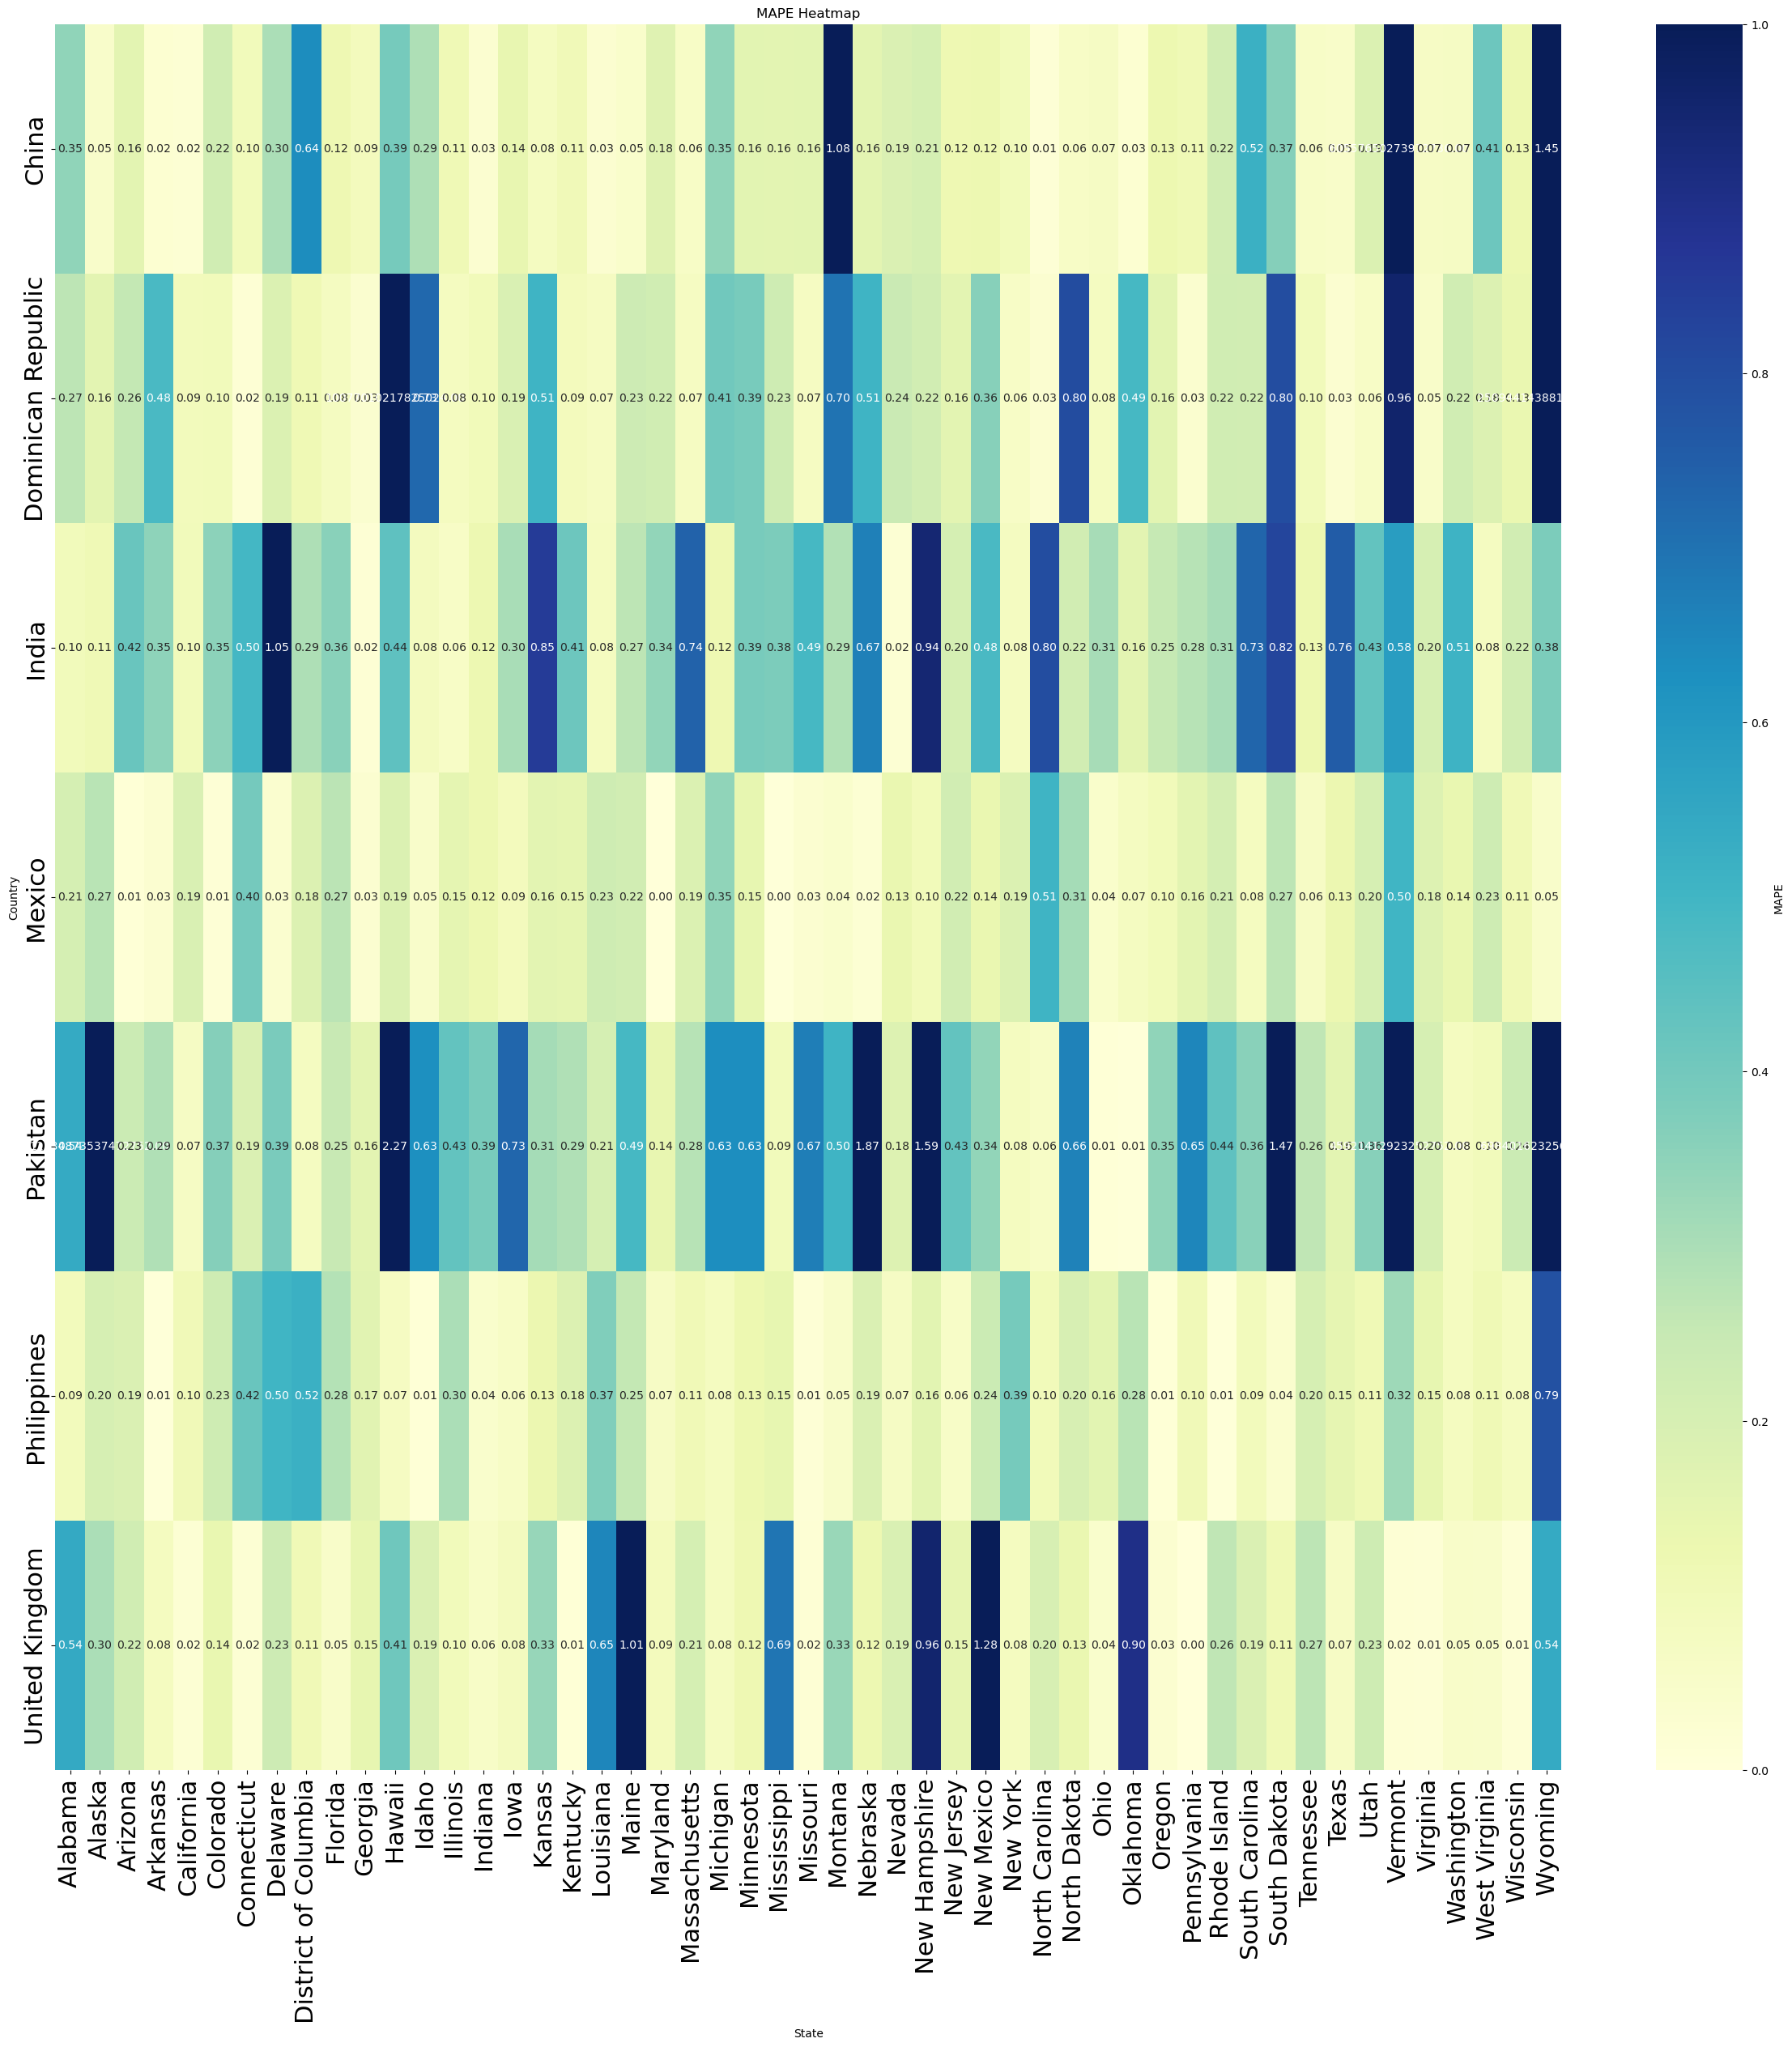

In [37]:
# Reshape the DataFrame to a pivot table for the heatmap
heatmap_df = df_scores.pivot(index='Country', columns='State', values='MAPE')  # You can choose 'MAPE' here if needed

# Plot the heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'MAPE'},vmin=0, vmax=1)  # You can choose 'MAPE' here if needed
plt.title('MAPE Heatmap')
plt.xlabel('State')
plt.ylabel('Country')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.show()

In [39]:
display(df_scores[(df_scores['State'] == 'Wyoming') & (df_scores['Country'] == 'Philippines')])

,Country,State,R2 Score,RMSE,MAPE,MEDAE,CVRMSE,data2019,pred2019
356,Philippines,Wyoming,NaN,24.364678,0.785957,24.364678,78.595734,[31],55.364678


In [41]:
display(df_scores[(df_scores['State'] == 'West Virginia') & (df_scores['Country'] == 'Dominican Republic')])

,Country,State,R2 Score,RMSE,MAPE,MEDAE,CVRMSE,data2019,pred2019
150,Dominican Republic,West Virginia,NaN,1.632259,0.181362,1.632259,18.136206,[9],7.367741


In [43]:
display(df_scores[(df_scores['State'] == 'California') & (df_scores['Country'] == 'United Kingdom')])

,Country,State,R2 Score,RMSE,MAPE,MEDAE,CVRMSE,data2019,pred2019
208,United Kingdom,California,NaN,46.796054,0.021776,46.796054,2.177573,[2149],2195.796054
